
# PET TOF sinogram projector

In this example we will show how to setup and use a TOF PET sinogram projector
consisting of a geometrical TOF forward projector (Joseph's method), 
a resolution model and a correction for attenuation.

.. tip::
    parallelproj is python array API compatible meaning it supports different 
    array backends (e.g. numpy, cupy, torch, ...) and devices (CPU or GPU).
    Choose your preferred array API ``xp`` and device ``dev`` below.

<img src="https://mybinder.org/badge_logo.svg" target="https://mybinder.org/v2/gh/gschramm/parallelproj/master?labpath=examples">


parallelproj supports the numpy, cupy and pytorch array API and different devices
choose your preferred array API uncommenting the corresponding line



In [16]:
import array_api_compat.numpy as xp

# import array_api_compat.cupy as xp
# import array_api_compat.torch as xp

import parallelproj
from array_api_compat import to_device
import array_api_compat.numpy as np
import matplotlib.pyplot as plt

# choose a device (CPU or CUDA GPU)
if "numpy" in xp.__name__:
    # using numpy, device must be cpu
    dev = "cpu"
elif "cupy" in xp.__name__:
    # using cupy, only cuda devices are possible
    dev = xp.cuda.Device(0)
elif "torch" in xp.__name__:
    # using torch valid choices are 'cpu' or 'cuda'
    dev = "cuda"

setup a small regular polygon PET scanner with 5 rings (polygons)



In [17]:
num_rings = 4
scanner = parallelproj.RegularPolygonPETScannerGeometry(
    xp,
    dev,
    radius=65.0,
    num_sides=12,
    num_lor_endpoints_per_side=15,
    lor_spacing=2.3,
    ring_positions=xp.linspace(-4, 4, num_rings),
    symmetry_axis=1,
)

setup the LOR descriptor that defines the sinogram



In [18]:
lor_desc = parallelproj.RegularPolygonPETLORDescriptor(
    scanner,
    radial_trim=10,
    max_ring_difference=1,
    sinogram_order=parallelproj.SinogramSpatialAxisOrder.RVP,
)

## Defining a non-TOF projector

:class:`.RegularPolygonPETProjector` can be used to define a non-TOF projector
that combines the scanner, LOR and image geometry. The latter is defined by
the image shape, the voxel size, and the image origin.



In [19]:
# define a first projector using an image with 40x8x40 voxels of size 2x2x2 mm
# where the image center is at world coordinate (0, 0, 0)
proj = parallelproj.RegularPolygonPETProjector(
    lor_desc, img_shape=(40, 7, 40), voxel_size=(2.0, 2.0, 2.0)
)

## Visualize the scanner and image geometry

:meth:`.RegularPolygonPETProjector.show_geometry` can be used
to visualize the scanner and image geometry



C:\Users\holot\AppData\Local\Temp\ipykernel_11372\3117533619.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


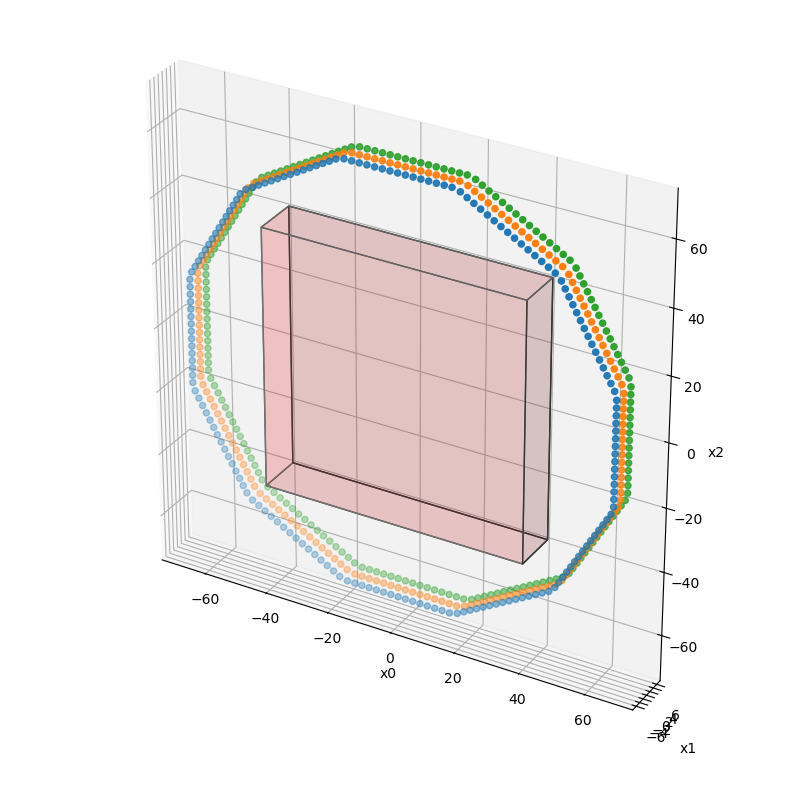

In [5]:
fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(111, projection="3d")
proj.show_geometry(ax1)
fig.tight_layout()
fig.show()

## Adding an image-based resolution model



In [6]:
# setup a simple image-based resolution model with an Gaussian FWHM of 4.5mm
res_model = parallelproj.GaussianFilterOperator(
    proj.in_shape, sigma=4.5 / (2.35 * proj.voxel_size)
)

## Calculation of the non-TOF attenuation sinogram



In [7]:
# setup an attenuation image containing the attenuation coeff. of water
# (in 1/mm)
x_att = xp.full(proj.in_shape, 0.01, device=dev, dtype=xp.float32)

# forward project the attenuation image
x_att_fwd = proj(x_att)

# calculate the attenuation sinogram
att_sino = xp.exp(-x_att_fwd)

## Adding time-of-flight to the projector



In [8]:
proj.tof_parameters = parallelproj.TOFParameters(num_tofbins=9)

## Combining resolution model, TOF projector and attenuation model

Since the attenuation sinogram is a non-TOF sinogram with shape = (161, 90, 7) and
the output of the projector is a TOF sinogram with shape = (161, 90, 7, num_tofbins),
we have to use the :class:`.TOFNonTOFElementwiseMultiplicationOperator` to add the
attenuation model to the forward model.



In [9]:
print(f"atten. sino shape {att_sino.shape}")
print(f"proj output shape {proj.out_shape}")

att_op = parallelproj.TOFNonTOFElementwiseMultiplicationOperator(
    proj.out_shape, att_sino
)

# setup a forward projector containing the attenuation and resolution
proj_with_att_and_res_model = parallelproj.CompositeLinearOperator(
    (att_op, proj, res_model)
)

atten. sino shape (161, 90, 7)
proj output shape (161, 90, 7, 9)


## setup a simple test image containing a few "hot rods"



In [10]:
# setup a simple test image containing a few "hot rods"
x = xp.zeros(proj.in_shape, device=dev, dtype=xp.float32)
x[proj.in_shape[0] // 2, :, proj.in_shape[2] // 2] = 1.0
x[4, 3:, proj.in_shape[2] // 2] = 1.0
x[proj.in_shape[0] // 2, :-3, 4] = 1.0

## forward and back project the image



In [15]:
%%timeit -n 1
x_fwd = proj_with_att_and_res_model(x)
x_fwd_back = proj_with_att_and_res_model.adjoint(x_fwd)

21 ms ± 513 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


## visualize the forward and the back projection



C:\Users\holot\AppData\Local\Temp\ipykernel_11372\1589487106.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\holot\AppData\Local\Temp\ipykernel_11372\1589487106.py:37: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig2.show()


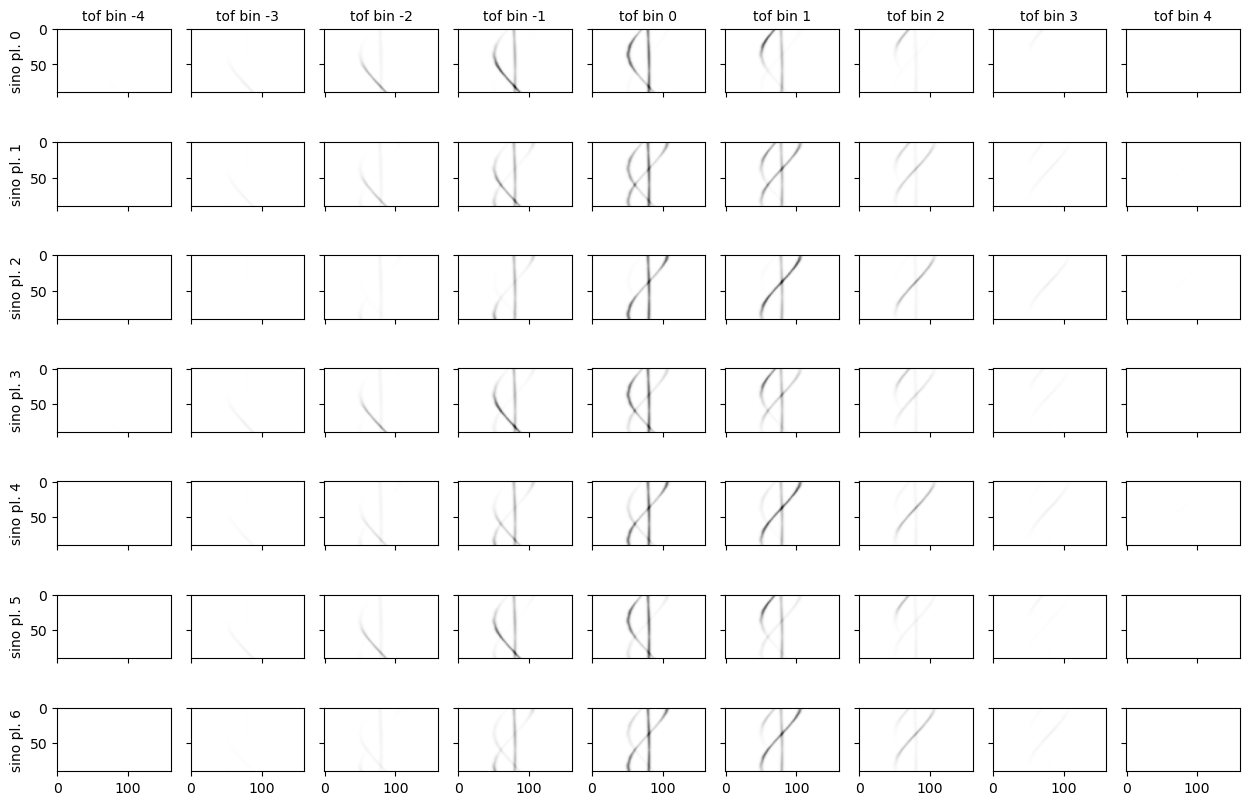

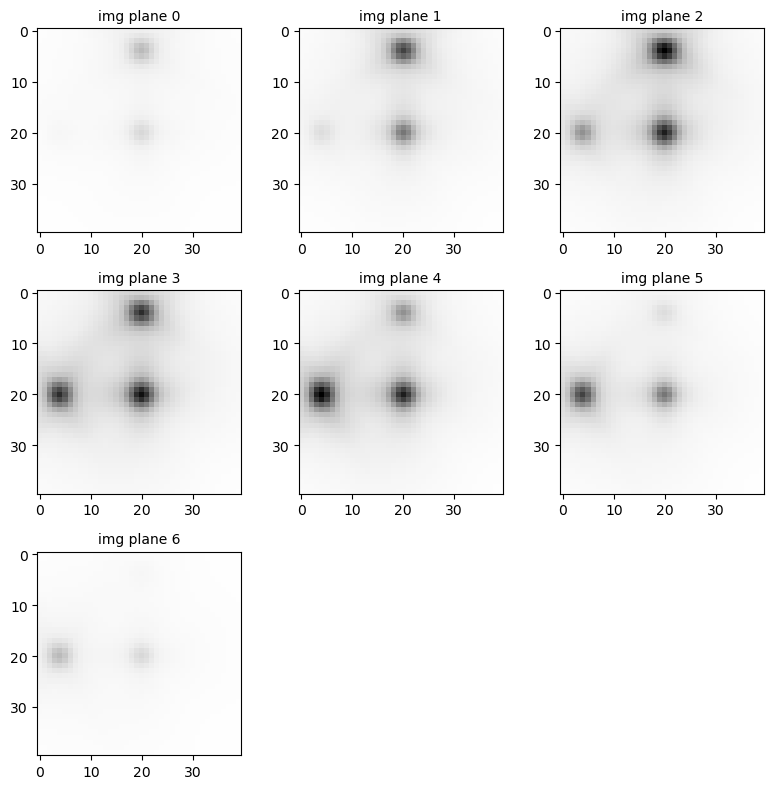

In [12]:
fig, ax = plt.subplots(7, 9, figsize=(1.4 * 9, 1.2 * 7), sharex=True, sharey=True)
vmax = float(xp.max(x_fwd))
for i in range(7):
    for j in range(9):
        ax[i, j].imshow(
            parallelproj.to_numpy_array(x_fwd[:, :, i, j].T),
            cmap="Greys",
            vmin=0,
            vmax=vmax,
        )
        if i == 0:
            ax[i, j].set_title(
                f"tof bin {j - proj.tof_parameters.num_tofbins//2}", fontsize="medium"
            )
        if j == 0:
            ax[i, j].set_ylabel(f"sino pl. {i}", fontsize="medium")
        # ax[i,j].set_axis_off()
fig.tight_layout()
fig.show()


# visualize the back projection including the attenuation resolution model
fig2, ax2 = plt.subplots(3, 3, figsize=(8, 8))
vmax = float(xp.max(x_fwd_back))
for i, axx in enumerate(ax2.ravel()):
    if i < x_fwd_back.shape[1]:
        axx.imshow(
            parallelproj.to_numpy_array(x_fwd_back[:, i, :].T),
            cmap="Greys",
            vmin=0,
            vmax=vmax,
        )
        axx.set_title(f"img plane {i}", fontsize="medium")
    else:
        axx.set_axis_off()
fig2.tight_layout()
fig2.show()